# Model Consolidation

### Libraries

In [34]:
import numpy as np
import matplotlib.pyplot as plt   
%matplotlib inline
from music21 import *
from IPython.display import Audio
from intervaltree import Interval,IntervalTree
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import sklearn.model_selection as model_selection
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


mn_data = np.load('musicnet.npz','rb',allow_pickle=True)

### Import csv features which were extracted from earlier Data PreProcessing notebook

In [5]:
#Get metadata
#metadata=pd.read_csv('../data/musicnet_metadata.csv')

# Get consolidated saved csvs of WAV Spectral features only
#train_wav = pd.read_csv('../data/df_train_wav_consolidated.csv',index_col=0)
#test_wav = pd.read_csv('../data/df_test_wav_finc.csv',index_col=0)

#Get midi features only
#midi_features = pd.read_csv('../data/midi_features.csv',index_col=0)

metadata=pd.read_csv('cvs_data/musicnet_metadata.csv')

# Get consolidated saved csvs of WAV Spectral features only
train_wav = pd.read_csv('cvs_data/df_train_wav_consolidated.csv',index_col=0)
test_wav = pd.read_csv('cvs_data/df_test_wav_finc.csv',index_col=0)

#Get midi features only
midi_features = pd.read_csv('cvs_data/midi_features.csv',index_col=0)

### Import Wav Data for Spectral Features only

In [6]:
#Create X and y for Wav Data only

#Make a copy of the metadata
meta_data_copy = metadata.copy(deep=True)
meta_data_copy.reset_index(inplace=True)

#Rename column name
meta_data_copy = meta_data_copy.rename(columns = {'id':'filename'})

#Merge Metadata and Wav Data Only
merged_train_data_w = pd.merge(train_wav , meta_data_copy , on="filename")
merged_train_data_w = merged_train_data_w.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

merged_test_data_w = pd.merge(test_wav , meta_data_copy , on="filename")
merged_test_data_w = merged_test_data_w.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

#Checked that unique ensembles in test are a subset of train
#Get list of unique ensembles
ens_list = merged_train_data_w['ensemble'].unique()

#Map list of unique ensemble names to integer
mapping = {item:i for i, item in enumerate(ens_list)}
merged_train_data_w["ensemble"] = merged_train_data_w["ensemble"].apply(lambda x: mapping[x])
merged_test_data_w["ensemble"] = merged_test_data_w["ensemble"].apply(lambda x: mapping[x])

#This is the original train test split given in kaggle. 
#The code is selecting only the ensemble for the y and letting the rest of the features be in X

X_original_train = merged_train_data_w.iloc[:,np.r_[:167,168]]
X_original_test = merged_test_data_w.iloc[:,np.r_[:167,168]]

y_original_train = merged_train_data_w.iloc[:,167:168]
y_original_test = merged_test_data_w.iloc[:,167:168]

#Concatenate the training and test data
x_frames = [X_original_train,X_original_test]
X_wav = pd.concat(x_frames , ignore_index=True)

y_frames = [y_original_train,y_original_test]
y_wav = pd.concat(y_frames , ignore_index=True)

#Find the index position of viola quintet and drop it since there is only one ensemble of that type
index_violaquintet_wav_only = y_wav[ y_wav['ensemble'] == 3 ].index
y_wav.drop(index_violaquintet_wav_only , inplace=True)
X_wav.drop(index_violaquintet_wav_only , inplace=True)

#This is the train test split for Spectral Wav Data only
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

C:\Users\nojed\anaconda3\lib\site-packages\pandas\core\frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Print list of ensembles for reference

In [7]:
#print ensemble list
ens_list

array(['Piano Quintet', 'Solo Piano', 'Piano Trio', 'Viola Quintet',
       'String Quartet', 'Clarinet Quintet',
       'Pairs Clarinet-Horn-Bassoon', 'Wind Quintet', 'Accompanied Cello',
       'Accompanied Clarinet', 'Wind and Strings Octet', 'String Sextet',
       'Piano Quartet', 'Horn Piano Trio', 'Solo Violin', 'Solo Flute',
       'Solo Cello', 'Violin and Harpsichord',
       'Clarinet-Cello-Piano Trio', 'Accompanied Violin', 'Wind Octet'],
      dtype=object)

### Import MIDI Features for Engineered Features from Granular Data

In [8]:
#Create X and y for Granular MIDI Data Attributes only

#Make a copy of the midi features
midi_features_copy = midi_features.copy(deep=True)
midi_features_copy.reset_index(inplace=True)

#Rename column name in both the copy and the original
midi_features_copy = midi_features_copy.rename(columns = {'file_name':'filename'})
midi_features = midi_features.rename(columns = {'file_name':'filename'})


#Merge Metadata and MIDI Data only

#For original midi
merged_midi_data = pd.merge(midi_features , meta_data_copy , on="filename")
merged_midi_data = merged_midi_data.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index"], axis=1)

#For midi copy
merged_midi_data_copy = pd.merge(midi_features_copy , meta_data_copy , on="filename")
merged_midi_data_copy = merged_midi_data_copy.drop(["composer", "composition", "movement","source","transcriber","catalog_name","index_x"], axis=1)

#Map list of unique ensemble names to integer

#For original midi
merged_midi_data["ensemble"] = merged_midi_data["ensemble"].apply(lambda x: mapping[x])

#For midi copy
merged_midi_data_copy["ensemble"] = merged_midi_data_copy["ensemble"].apply(lambda x: mapping[x])

#To select data for train and test for midi based on the same splits done for wav based on multiple conditions you can use &:
#Removes file name as a feature and also removes viola quintet
midi_train = merged_midi_data.loc[merged_midi_data['filename'].isin(filenames_in_train)]
X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

midi_test = merged_midi_data.loc[merged_midi_data['filename'].isin(filenames_in_test)]
X_test_m = midi_test.iloc[:,np.r_[1:10,11]]
y_test_m = midi_test.iloc[:,np.r_[10]]

### Create Merged Dataset comprising Engineered Features from MIDI Data and Spectral Features from Wav Data

In [9]:
# Create Dataset with MIDI and WAV Spectral Data

#Drop duplicate columns
merged_midi_data_copy.drop(['seconds','index_y'],axis=1,inplace=True) 

#Find the index position of viola quintet and drop it since there is only one ensemble of that type
index_violaquintet_midi_only = merged_midi_data_copy[ merged_midi_data_copy['ensemble'] == 3 ].index
merged_midi_data_copy.drop(index_violaquintet_midi_only , inplace=True)

#Merge Midi and Wav Data 
merged_data_c = pd.merge(X_wav, merged_midi_data_copy , on="filename")

#To select data for train and test for midi based on the same splits done for wav based on multiple conditions you can use &:
#Removes file name as a feature and also removes viola quintet
comb_train = merged_data_c.loc[merged_data_c['filename'].isin(filenames_in_train)]
X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]

comb_test = merged_data_c.loc[merged_data_c['filename'].isin(filenames_in_test)]
X_test_c = comb_test.iloc[:,np.r_[0,2:177]]
y_test_c = comb_test.iloc[:,np.r_[177]]

In [10]:
print('Shape of Wav Data :')
print( X_train_w.shape, y_train_w.shape , X_test_w.shape , y_test_w.shape)

Shape of Wav Data :
(263, 167) (263, 1) (66, 167) (66, 1)


In [11]:
print('Shape of MIDI Data :')
print( X_train_m.shape, y_train_m.shape , X_test_m.shape , y_test_m.shape)

Shape of MIDI Data :
(263, 10) (263, 1) (66, 10) (66, 1)


In [12]:
print('Shape of Combined Wav and MIDI Data :')
print( X_train_c.shape, y_train_c.shape , X_test_c.shape , y_test_c.shape)

Shape of Combined Wav and MIDI Data :
(263, 176) (263, 1) (66, 176) (66, 1)


# Models

## 1. Logistic Regression

### 1.1 Spectral (WAV) Data Only

#### 1.1.1 Baseline model

In [16]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_w), np.array(y_train_w))
scores = cross_val_score(estimator = lr, X=X_train_w, y=y_train_w, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.88679245 0.88679245 0.86792453 0.90384615 0.94230769]
CV Average and standard deviation:  0.8975326560232221 +/- 0.02510780470472868


#### 1.1.2 PCA components

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

[0.8496704647266673, 0.9432045674275258, 0.9657437073371651, 0.9740154026128449, 0.980814681037099, 0.9842105572644043, 0.9869234364301775, 0.9895492330696728]


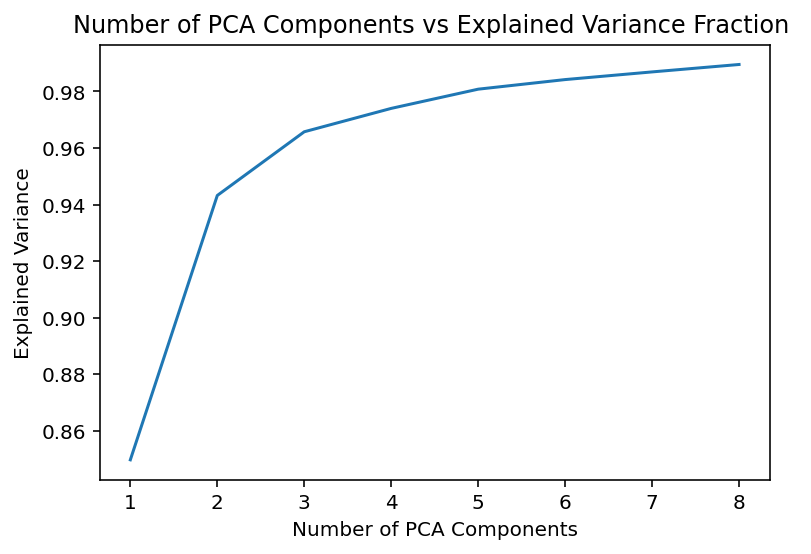

Linear regression
CV Scores:  [0.67924528 0.69811321 0.66037736 0.71153846 0.69230769]
CV Average and standard deviation:  0.6883164005805515 +/- 0.017401420621599144


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

In [26]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_w.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_w)
X_train_pca = pca.transform(X_train_w)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_w)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))
      

### 1.2 MIDI Data Only 

#### 1.2.1 Baseline model

In [17]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_m), np.array(y_train_m))
scores = cross_val_score(estimator = lr, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.69811321 0.75471698 0.67924528 0.65384615 0.76923077]
CV Average and standard deviation:  0.7110304789550072 +/- 0.044142917620219664


#### 1.2.2 PCA components

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

[0.847246925156634, 0.9999994828649594, 0.9999999950423858, 0.9999999979326264, 0.9999999995373896, 0.9999999998110075, 0.9999999999006715, 0.9999999999631857]


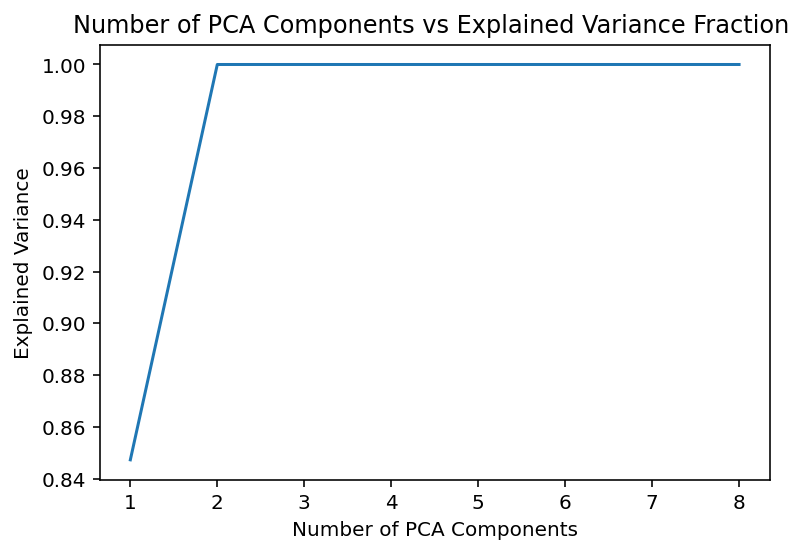

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.47169811 0.47169811 0.16981132 0.48076923 0.48076923]
CV Average and standard deviation:  0.4149492017416546 +/- 0.1226360559071233


In [28]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_m.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_m)
    train_pca = pca.transform(X_train_m)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_m)
X_train_pca = pca.transform(X_train_m)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_w)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))


### 1.3 Combined Data (WAV & MIDI) 

#### 1.3.1 Baseline model

In [18]:
lr = LogisticRegression(C = 0.5, solver='liblinear', multi_class='auto')
lr.fit(np.array(X_train_c), np.array(y_train_c))
scores = cross_val_score(estimator = lr, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.81132075 0.86792453 0.90566038 0.82692308 0.90384615]
CV Average and standard deviation:  0.863134978229318 +/- 0.038690476180831046


#### 1.3.2 PCA components

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\svm\_ba

[0.8472467564714535, 0.9999993006005323, 0.9999998191050802, 0.9999999250480672, 0.9999999510448121, 0.9999999628415001, 0.9999999703478009, 0.9999999753281146]


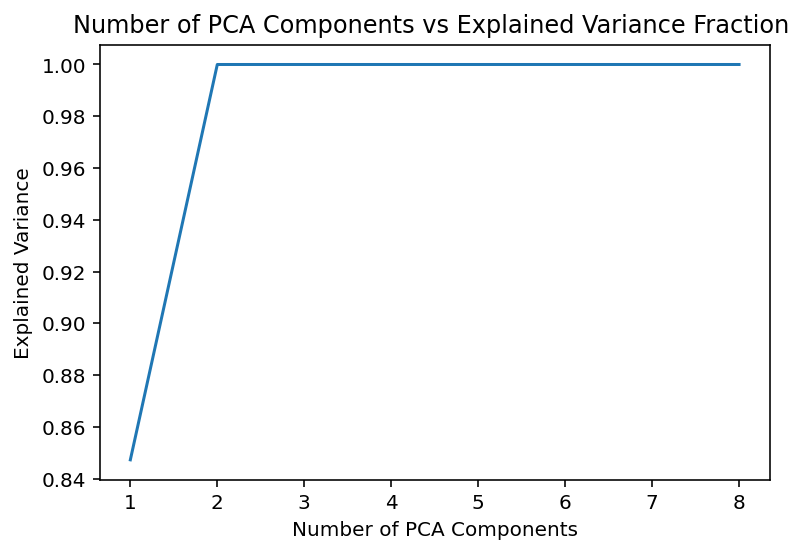

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

Linear regression
CV Scores:  [0.47169811 0.43396226 0.45283019 0.48076923 0.46153846]
CV Average and standard deviation:  0.4601596516690857 +/- 0.016123374972447535


In [30]:
#all possible values of principal components can go up to the number of features
all_possible_k = range(1,len(X_train_c.columns))

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca = PCA(n_components = i)
    pca.fit(X_train_c)
    train_pca = pca.transform(X_train_c)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    
    #Logistic Regression Model with PCA
    lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
    lr.fit(train_pca,y_train_w)

plt.plot(all_possible_k[0:8], all_possible_k_variance[0:8])
print(all_possible_k_variance[0:8])

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

pca = PCA(n_components = 5)
pca.fit(X_train_c)
X_train_pca = pca.transform(X_train_c)

lr = LogisticRegression(C = 0.5, max_iter = 100,solver='liblinear', multi_class='auto')
lr.fit(X_train_pca,y_train_c)
scores = cross_val_score(estimator = lr, X=X_train_pca, y=y_train_w, cv=5, n_jobs=1)
print('Linear regression')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))


---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [31]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


C:\Users\nojed\anaconda3\lib\site-packages\pandas\core\frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## 2. Naive Bayes

### 2.1 Spectral (WAV) Data Only

#### 2.1.1 Baseline model

In [35]:
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_w, y=y_train_w, cv=5, n_jobs=1)
print('Naive Bayes')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Naive Bayes
CV Scores:  [0.69811321 0.71698113 0.71698113 0.67307692 0.61538462]
CV Average and standard deviation:  0.6841074020319303 +/- 0.0379526539589294


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

#### 2.1.2 PCA components

### 2.2 MIDI Data Only

#### 2.2.1 Baseline model

In [36]:
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
print('Naive Bayes')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Naive Bayes
CV Scores:  [0.58490566 0.32075472 0.69811321 0.59615385 0.75      ]
CV Average and standard deviation:  0.5899854862119013 +/- 0.14821964049306927


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

#### 2.2.2 PCA components

### 2.3 Combined Data (WAV & MIDI)

#### 2.3.1 Baseline model

In [37]:
gnb = GaussianNB()
scores = cross_val_score(estimator = gnb, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Naive Bayes')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Naive Bayes
CV Scores:  [0.71698113 0.75471698 0.73584906 0.75       0.69230769]
CV Average and standard deviation:  0.7299709724238026 +/- 0.02295795020311934


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*

#### 2.3.2 PCA components

---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


## 3. Decision Tree

### 3.1 Spectral (WAV) Data Only

#### 3.1.1 Baseline model

In [38]:
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_w, y=y_train_w, cv=5, n_jobs=1)
print('Decision Tree')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Decision Tree
CV Scores:  [0.71698113 0.75471698 0.67924528 0.78846154 0.71153846]
CV Average and standard deviation:  0.730188679245283 +/- 0.03772230972918628


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


#### 3.1.2 PCA components

### 3.2 MIDI Data Only

#### 3.2.1 Baseline model

In [39]:
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
print('Decision Tree')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Decision Tree
CV Scores:  [0.83018868 0.77358491 0.83018868 0.90384615 0.82692308]
CV Average and standard deviation:  0.8329462989840348 +/- 0.04147783160686735


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


#### 3.1.2 PCA components

### 3.3 Combined Data (WAV & MIDI)

#### 3.3.1 Baseline model

In [40]:
dt = DecisionTreeClassifier()
scores = cross_val_score(estimator = dt, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Decision Tree')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

Decision Tree
CV Scores:  [0.79245283 0.79245283 0.83018868 0.90384615 0.92307692]
CV Average and standard deviation:  0.8484034833091437 +/- 0.055213662402209


C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


#### 3.3.2 PCA components

---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


## 4. Random Forest

### 4.1 Spectral (WAV) Data Only

#### 4.1.1 Baseline model

<ipython-input-44-290332bb42d9>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_w, y_train_w)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estima

Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only WAV data
CV Scores:  [0.8490566  0.81132075 0.73584906 0.86538462 0.86538462]
CV Average and standard deviation:  0.8253991291727141 +/- 0.0489382681428624


<AxesSubplot:>

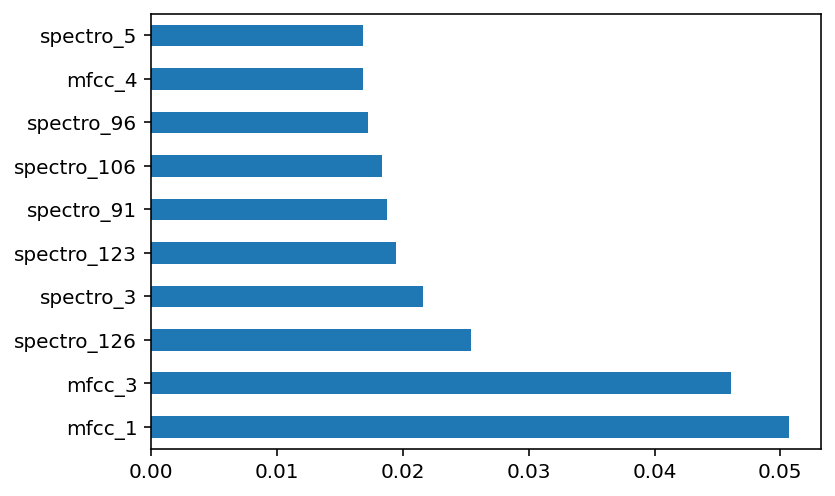

In [44]:
rf = RandomForestClassifier()
rf.fit(X_train_w, y_train_w)
scores = cross_val_score(estimator = rf, X=X_train_w, y=y_train_w, cv=5, n_jobs=1)
print('Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

feat_importances = pd.Series(rf.feature_importances_, index=X_train_w.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### 4.1.2 Sampling (SMOTE), no hyperparameter tuning

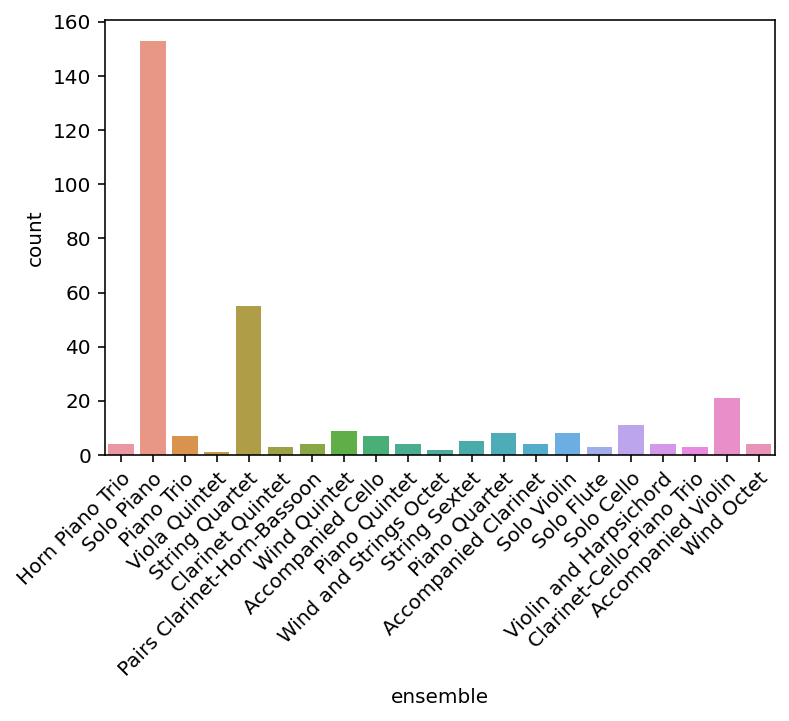

(231, 167) (231, 1)
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6})
Resample dataset shape Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})


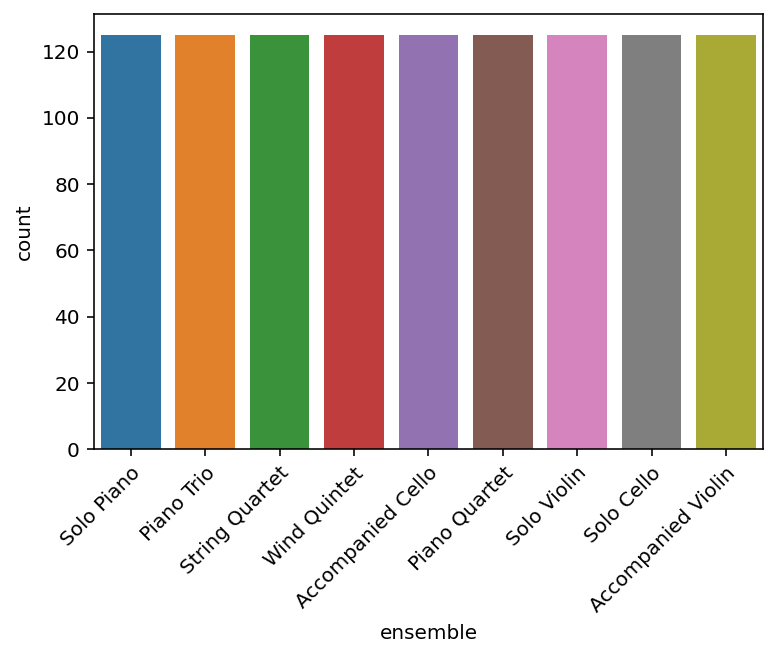

<ipython-input-48-dfb0bb9ca462>:62: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_SMOTE_w, y_SMOTE_w)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Random Forest: Sample with SMOTE, no hyperparameter tuning / Only WAV data
CV Scores:  [0.99555556 0.98666667 0.99555556 1.         1.        ]
CV Average and standard deviation:  0.9955555555555555 +/- 0.004868644955601467


<AxesSubplot:>

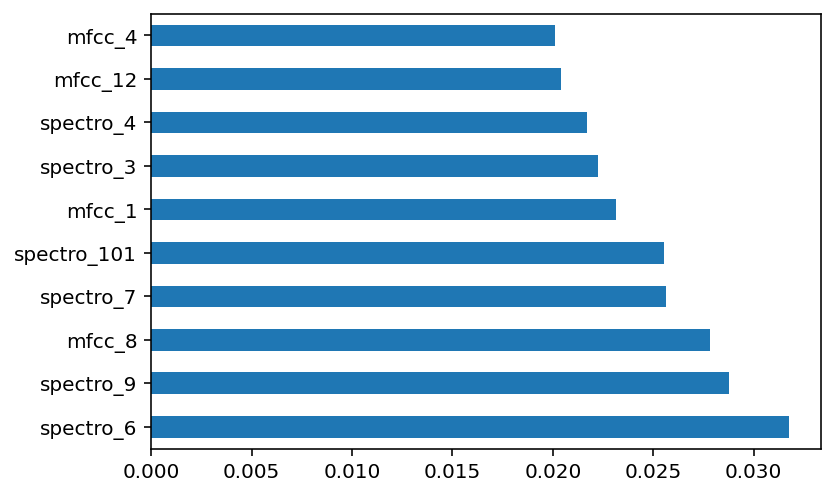

In [48]:
# Visualize the target variable
g = sns.countplot(merged_train_data_w['ensemble'])
g.set_xticklabels(['Horn Piano Trio',
'Solo Piano',
'Piano Trio',
'Viola Quintet',
'String Quartet',
'Clarinet Quintet',
'Pairs Clarinet-Horn-Bassoon',
'Wind Quintet',
'Accompanied Cello',
'Piano Quintet',
'Wind and Strings Octet',
'String Sextet',
'Piano Quartet',
'Accompanied Clarinet',
'Solo Violin',
'Solo Flute',
'Solo Cello',
'Violin and Harpsichord',
'Clarinet-Cello-Piano Trio',
'Accompanied Violin',
'Wind Octet'],rotation_mode='anchor',rotation=45, ha='right')
plt.show()

#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_w['ensemble'].value_counts()
X_train_w = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
print(X_train_w.shape, y_train_w.shape)

#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.


# Fit and apply the transform
X_SMOTE_w, y_SMOTE_w = SMOTE(random_state=101).fit_resample(X_train_w, y_train_w)

print('Original dataset shape', Counter(y_train_w.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_w.values.ravel()))

# Visualize the target variable
g = sns.countplot(y_SMOTE_w['ensemble'])
g.set_xticklabels([
'Solo Piano', 
'Piano Trio',
'String Quartet',
'Wind Quintet',
'Accompanied Cello',
'Piano Quartet',
'Solo Violin',
'Solo Cello',
'Accompanied Violin'],rotation_mode='anchor',rotation=45, ha='right')
plt.show()

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_w, y_SMOTE_w)
scores = cross_val_score(estimator = rf, X=X_SMOTE_w, y=y_SMOTE_w, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, no hyperparameter tuning / Only WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2

feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_w.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### 4.1.3 Sampling (SMOTE), hyperparameter tuning

In [ ]:
rf = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 75, 100, 125, 150, 175, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 3, 4, 5, 6]
}
clf = GridSearchCV(rf , model_params, cv=5) # set up grid search meta-estimator
clf.fit(X_SMOTE_w, y_SMOTE_w)
scores = cross_val_score(estimator = clf, X=X_SMOTE_w, y=y_SMOTE_w, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, hyperparameter tuning / Only WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

print(clf.best_params_)

feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_w.columns)
feat_importances.nlargest(10).plot(kind='barh')

### 4.2 MIDI Data Only

#### 4.2.1 Baseline model

<ipython-input-52-0906a5f5ca5c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_m, y_train_m)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y t

Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only MIDI data
CV Scores:  [0.9787234  0.89130435 0.97826087 1.         0.95652174]
CV Average and standard deviation:  0.9609620721554115 +/- 0.03744486142663875


<AxesSubplot:>

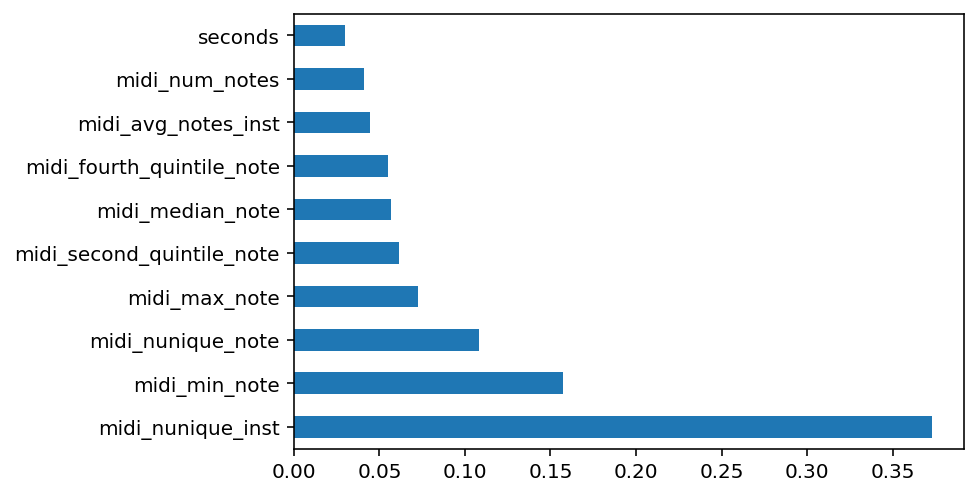

In [52]:
rf = RandomForestClassifier()
rf.fit(X_train_m, y_train_m)
scores = cross_val_score(estimator = rf, X=X_train_m, y=y_train_m, cv=5, n_jobs=1)
print('Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Only MIDI data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

feat_importances = pd.Series(rf.feature_importances_, index=X_train_m.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### 4.2.2 Sampling (SMOTE), no hyperparameter tuning

(231, 10) (231, 1)
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 7: 7, 14: 7, 2: 6, 8: 6, 12: 6})
Resample dataset shape Counter({1: 125, 2: 125, 4: 125, 7: 125, 8: 125, 12: 125, 14: 125, 16: 125, 19: 125})


<ipython-input-53-5d6feb541bc7>:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_SMOTE_m, y_SMOTE_m)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Random Forest: Sample with SMOTE, no hyperparameter tuning / Only MIDI data
CV Scores:  [0.99555556 0.99555556 0.99555556 0.99555556 0.98666667]
CV Average and standard deviation:  0.9937777777777776 +/- 0.003555555555555534


<AxesSubplot:>

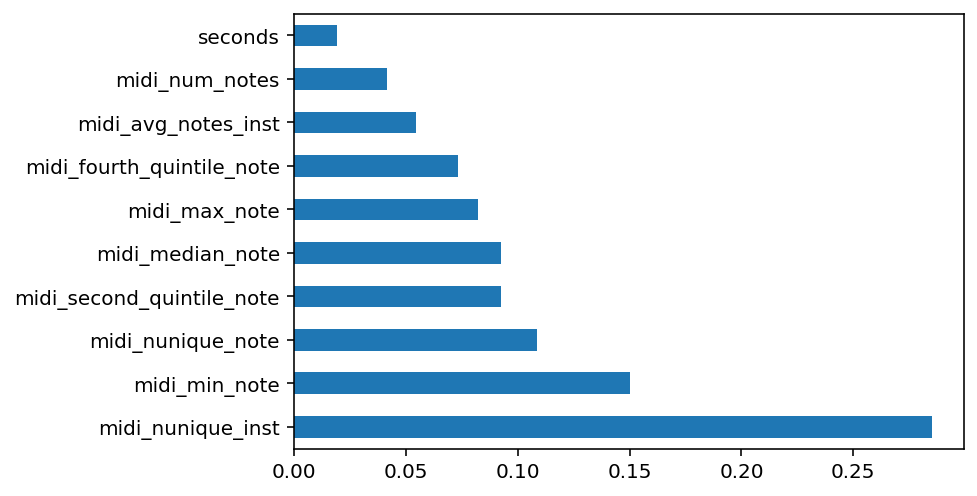

In [53]:
#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_m['ensemble'].value_counts()
X_train_m = X_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
y_train_m = y_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
print(X_train_m.shape, y_train_m.shape)

#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.

# Fit and apply the transform
X_SMOTE_m, y_SMOTE_m = SMOTE(random_state=101).fit_resample(X_train_m, y_train_m)

print('Original dataset shape', Counter(y_train_m.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_m.values.ravel()))

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_m, y_SMOTE_m)
scores = cross_val_score(estimator = rf, X=X_SMOTE_m, y=y_SMOTE_m, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, no hyperparameter tuning / Only MIDI data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2
    
feat_importances = pd.Series(rf.feature_importances_, index=X_train_m.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### 4.2.3 Sampling (SMOTE), hyperparameter tuning

In [ ]:
rf = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 75, 100, 125, 150, 175, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 3, 4, 5, 6]
}
clf = GridSearchCV(rf , model_params, cv=5) # set up grid search meta-estimator
clf.fit(X_SMOTE_m, y_SMOTE_m)
scores = cross_val_score(estimator = clf, X=X_SMOTE_m, y=y_SMOTE_m, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, hyperparameter tuning / Only MIDI data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

print(clf.best_params_)

feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_m.columns)
feat_importances.nlargest(10).plot(kind='barh')

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was pa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was pas

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

### 4.3 Combined Data (WAV & MIDI)

#### 4.3.1 Baseline model

<ipython-input-54-b00466b1ec69>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_c, y_train_c)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estima

Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Both MIDI & WAV data
CV Scores:  [0.77358491 0.88679245 0.83018868 0.82692308 0.94230769]
CV Average and standard deviation:  0.8519593613933237 +/- 0.05765327156504294


<AxesSubplot:>

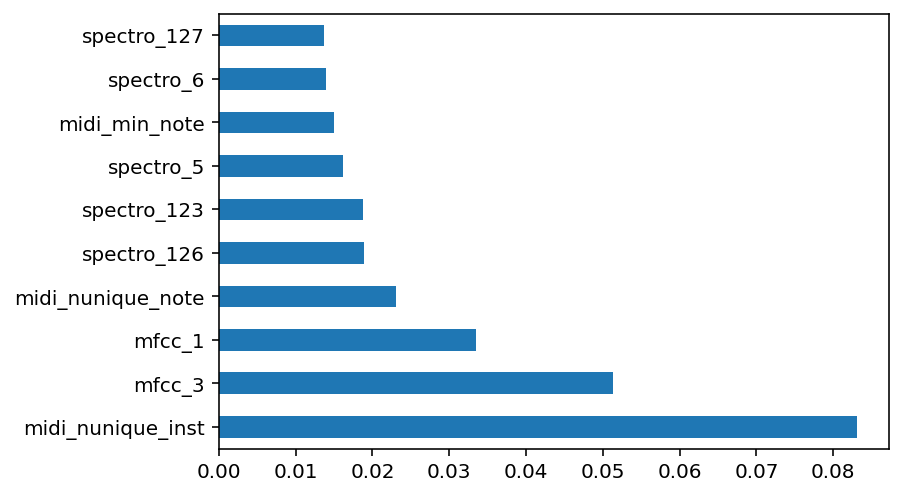

In [54]:
rf = RandomForestClassifier()
rf.fit(X_train_c, y_train_c)
scores = cross_val_score(estimator = rf, X=X_train_c, y=y_train_c, cv=5, n_jobs=1)
print('Random Forest: Sample as it is: No balancing, no hyperparameter tuning / Both MIDI & WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

feat_importances = pd.Series(rf.feature_importances_, index=X_train_c.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### 4.3.2 Sampling (SMOTE), no hyperparameter tuning

(231, 176) (231, 1)
Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 7: 7, 14: 7, 2: 6, 8: 6, 12: 6})
Resample dataset shape Counter({1: 125, 2: 125, 4: 125, 7: 125, 8: 125, 12: 125, 16: 125, 14: 125, 19: 125})


<ipython-input-56-4379194a5284>:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_SMOTE_c, y_SMOTE_c)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y 

Random Forest: Sample with SMOTE, no hyperparameter tuning / Both MIDI & WAV data
CV Scores:  [0.98666667 1.         0.98666667 0.99111111 1.        ]
CV Average and standard deviation:  0.9928888888888888 +/- 0.006028737762778003


<AxesSubplot:>

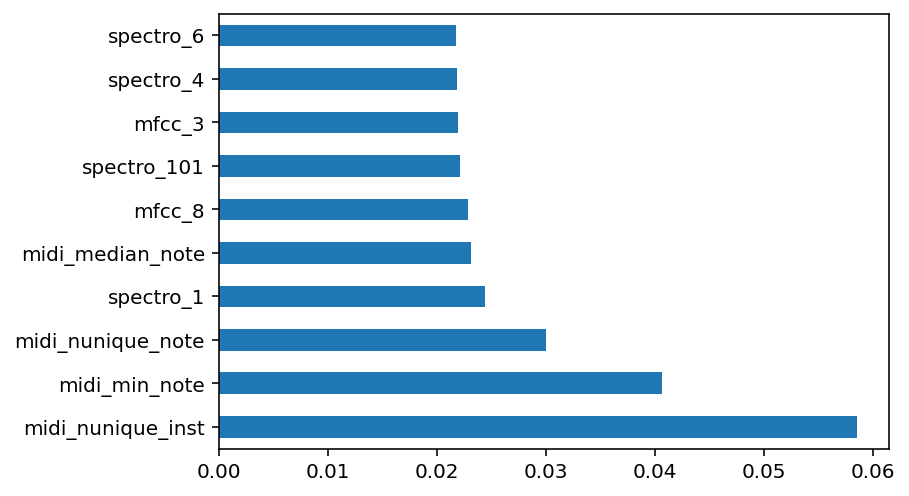

In [56]:
#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train_c['ensemble'].value_counts()
X_train_c = X_train_c[~y_train_c['ensemble'].isin(counts[counts < 6].index)]
y_train_c = y_train_c[~y_train_c['ensemble'].isin(counts[counts < 6].index)]
print(X_train_c.shape, y_train_c.shape)

#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.

X_SMOTE_c, y_SMOTE_c = SMOTE(random_state=101).fit_resample(X_train_c, y_train_c)

print('Original dataset shape', Counter(y_train_c.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE_c.values.ravel()))


from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=1)
rf.fit(X_SMOTE_c, y_SMOTE_c)
scores = cross_val_score(estimator = rf, X=X_SMOTE_c, y=y_SMOTE_c, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, no hyperparameter tuning / Both MIDI & WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2
    
feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_c.columns)
feat_importances.nlargest(10).plot(kind='barh')

#### 4.3.2 Sampling (SMOTE), hyperparameter tuning

In [57]:
rf = RandomForestClassifier(random_state=1)

model_params = {
    'n_estimators': [50, 75, 100, 125, 150, 175, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 3, 4, 5, 6]
}
clf = GridSearchCV(rf , model_params, cv=5) # set up grid search meta-estimator
clf.fit(X_SMOTE_c, y_SMOTE_c)
scores = cross_val_score(estimator = clf, X=X_SMOTE_c, y=y_SMOTE_c, cv=5, n_jobs=1)
print('Random Forest: Sample with SMOTE, hyperparameter tuning / Both MIDI & WAV data')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

print(clf.best_params_)

feat_importances = pd.Series(rf.feature_importances_, index=X_SMOTE_c.columns)
feat_importances.nlargest(10).plot(kind='barh')

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

KeyboardInterrupt: 

---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]


## 5. SVM

### 5.1 Spectral (WAV) Data Only

#### 5.1.1 Baseline model

In [ ]:
#Create baseline SVM model with Spectral Data

svm = make_pipeline(SVC())
svm.fit(X_train_w, y_train_w.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_w, y=y_train_w.values.ravel(), cv=5,n_jobs=1)
print('SVM Baseline with no hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### 5.1.2 Hyperparameter tuning

In [ ]:
#Find best hyperparameters
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),                     
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid, cv=5)
  
# fitting the model for grid search
grid.fit(X_train_w, y_train_w.values.ravel())

print(grid.best_params_)


#Create Model with best hyperparameters

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(X_train_w, y_train_w.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### 5.1.3 Hyperparameter tuning, PCA

In [ ]:
# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 166 i.e. one less than 167
all_possible_k = np.arange(1,167)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    


plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_train_w)
train_pca_w = pca.transform(X_train_w)

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w, y_train_w.values.ravel())

print(grid.best_params_)

#Create Model with best hyperparameters and PCA
svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w, y_train_w.values.ravel())


#Apply 5 fold cross validation scoring to make sure results are reliable
scores = cross_val_score(estimator = svm, X=train_pca_w, y=y_train_w.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning and PCA')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#Observation : PCA does not reduce score but reduces number of features to just 15 principal components

 #### 5.1.4 Hyperparameter tuning, PCA, SMOTE

In [ ]:
print("Before oversampling: ",Counter(y_train_w.values.ravel()))

#Drop any ensemble types with counts below 6
counts = y_train_w['ensemble'].value_counts()
X_train_w_smote = X_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]
y_train_w_smote = y_train_w[~y_train_w['ensemble'].isin(counts[counts < 6].index)]

#Now print data shape
print(X_train_w_smote.shape, y_train_w_smote.shape)

# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_w_smote, y_train_w_smote.values.ravel())

# summarize class distribution
print("After oversampling: ",Counter(y_SMOTE))

# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_w_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 166 i.e. one less than 167
all_possible_k = np.arange(1,167)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_w_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    

plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_SMOTE)
train_pca_w_smote = pca.transform(X_SMOTE)


from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_w_smote, y_SMOTE)

print(grid.best_params_)

#Create SVM model with best hyperparameters, PCA and SMOTE

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter, PCA and SMOTE tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### 5.1.5 Hyperparameter tuning, PCA, SMOTE, Min Max Scaler

In [ ]:
#### MinMaxScaler Application

#Create SVM model with best hyperparameters, PCA and SMOTE and MinMaxScaler

svm = make_pipeline(MinMaxScaler() ,SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and MinMax Scaler')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### 5.1.6 Hyperparameter tuning, PCA, SMOTE, Standard Scaler

In [ ]:
#### Standard Scaler Application

#Create SVM model with best hyperparameters, PCA and SMOTE and StandardScaler

svm = make_pipeline(StandardScaler() ,SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_w_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_w_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and Standard Scaler')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

### 5.2 MIDI Data Only

#### 5.2.1 Baseline model

In [ ]:
#Create baseline SVM model with MIDI Data only

svm = make_pipeline(SVC())
svm.fit(X_train_m, y_train_m.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_m, y=y_train_m.values.ravel(), cv=5,n_jobs=1)
print('SVM Baseline with no hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### 5.2.2 Hyperparameter tuning

#### This model with C = 545 could not complete running after 2 hours. This is possibly because of the features makes the calculation complex.

In [ ]:
#Find best hyperparameters
param_grid = {'C': np.logspace(-4, 4, 20)}
grid = GridSearchCV(SVC(), param_grid)
  
# fitting the model for grid search
grid.fit(X_train_m, y_train_m.values.ravel())

print(grid.best_params_)

#Create Model with best hyperparameters

svm = make_pipeline(SVC(kernel='linear', C = 545.559 ))
svm.fit(X_train_m, y_train_m.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_m, y=y_train_m.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### 5.2.3 SMOTE, PCA

In [ ]:
print("Before oversampling: ",Counter(y_train_m.values.ravel()))

#Drop any ensemble types with counts below 6
counts = y_train_m['ensemble'].value_counts()
X_train_m_smote = X_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]
y_train_m_smote = y_train_m[~y_train_m['ensemble'].isin(counts[counts < 6].index)]

#Now print data shape
print(X_train_m_smote.shape, y_train_m_smote.shape)


# fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train_m_smote, y_train_m_smote.values.ravel())

# summarize class distribution
print("After oversampling: ",Counter(y_SMOTE))

# Create list of K dimensions to test for PCA
p_comp = np.arange(1,10)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_m_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 9 i.e. one less than 10
all_possible_k = np.arange(1,10)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_SMOTE)
    train_pca_m_smote = pca.transform(X_SMOTE)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    

plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()

#Perform PCA with 2 components
pca=PCA(n_components = 2)
pca.fit(X_SMOTE)
train_pca_m_smote = pca.transform(X_SMOTE)

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20)} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_m_smote, y_SMOTE)

print(grid.best_params_)

#Create SVM model with best hyperparameters and SMOTE

svm = make_pipeline(SVC(kernel='linear', C = grid.best_params_['C'] ))
svm.fit(train_pca_m_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_m_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter and SMOTE tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### MinMaxScaler Application

#Create SVM model with best hyperparameters,SMOTE and MinMaxScaler

svm = make_pipeline(MinMaxScaler() ,SVC(kernel='linear', C = grid.best_params_['C'] ))
svm.fit(train_pca_m_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_m_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and MinMaxScaler')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### StandardScaler Application

#Create SVM model with best hyperparameters,  SMOTE and StandardScaler

svm = make_pipeline(MinMaxScaler() ,SVC(kernel='linear', C = grid.best_params_['C']))
svm.fit(train_pca_m_smote, y_SMOTE)
scores = cross_val_score(estimator = svm, X=train_pca_m_smote, y=y_SMOTE, cv=5, n_jobs=1)

#Apply 5 fold cross validation scoring to make sure results are reliable
print('SVM with hyperparameter tuning and StandardScaler')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### Models on MIDI Data could not be run due to long runtime (4 hours) for linear, rbf and polynomial kernels.

#### One clue we have here on why the SVM model struggles with classifying the MIDI data is that the best C value is extremely high at 10,000. In other words, very low regularization strength and extreme overfitting is required to fit the model well

### 5.3 Combined Data (WAV & MIDI)

#### 5.3.1 Baseline model

In [ ]:
#Create baseline SVM model with Spectral Wav and MIDI Data

svm = make_pipeline(SVC())
svm.fit(X_train_c, y_train_c.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_c, y=y_train_c.values.ravel(), cv=5,n_jobs=1)
print('SVM Baseline with no hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### 5.3.2 Hyperparameter tuning

In [ ]:
#Find best hyperparameters
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),                     
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid, cv=5)
  
# fitting the model for grid search
grid.fit(X_train_c, y_train_c.values.ravel())

print(grid.best_params_)


#Create Model with best hyperparameters

svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(X_train_c, y_train_c.values.ravel())

#Apply 5 fold cross validation scoring to make sure results are reliable

scores = cross_val_score(estimator = svm, X=X_train_c, y=y_train_c.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### 5.3.2 Hyperparameter tuning, PCA

In [ ]:
# Create list of K dimensions to test for PCA
p_comp = np.arange(1,25)


# Create empty list to store fraction of total variance
fraction_total_variance = []

# Write for loop to try k values for PCA
for i in p_comp:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    fraction_total_variance.append(np.sum(pca.explained_variance_ratio_))
    

#Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 2, 3, 4, 5, 10, 20, 30, 40, 50].    
variance_pca_df = pd.DataFrame({'Number of PCA Components':p_comp , 'Explained Fraction of Total Variance' :fraction_total_variance })

pd.set_option("display.max_rows", 500, "display.max_columns", 5, 'display.width', 1000)  
print(variance_pca_df)


#all possible values of k can go up to 175 i.e. one less than 176
all_possible_k = np.arange(1,176)

# Create empty list to store fraction of total variance
all_possible_k_variance = []

# Write for loop to try k values for PCA
for i in all_possible_k:
    pca=PCA(n_components = i)
    pca.fit(X_train_w)
    train_pca_w = pca.transform(X_train_w)
    
    #Append fractions of explained total variance
    all_possible_k_variance.append(np.sum(pca.explained_variance_ratio_))
    


plt.plot(all_possible_k, all_possible_k_variance)

# show lineplot of fraction of total variance vs. number of principal components, for all possible numbers of principal components.
# Add title and axis names
plt.title('Number of PCA Components vs Explained Variance Fraction ')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance')

plt.show()


#Perform PCA with 15 components
pca=PCA(n_components = 15)
pca.fit(X_train_c)
train_pca_c = pca.transform(X_train_c)

from sklearn.model_selection import GridSearchCV
  
# defining parameter range
param_grid = {'C': np.logspace(-4, 4, 20), 
              'gamma': np.logspace(-3, 2, 6),
              'kernel': ['linear','rbf','poly']} 
  
grid = GridSearchCV(SVC(), param_grid , cv=5)
  
# fitting the model for grid search
grid.fit(train_pca_c, y_train_c.values.ravel())

print(grid.best_params_)

#Create Model with best hyperparameters and PCA
svm = make_pipeline(SVC(kernel=grid.best_params_['kernel'], C = grid.best_params_['C'] , gamma=grid.best_params_['gamma']))
svm.fit(train_pca_c, y_train_c.values.ravel())


#Apply 5 fold cross validation scoring to make sure results are reliable
scores = cross_val_score(estimator = svm, X=train_pca_c, y=y_train_c.values.ravel(), cv=5, n_jobs=1)
print('SVM with hyperparameter tuning and PCA')
print('CV Scores: ', scores)
print('CV Average and standard deviation: ', np.mean(scores), '+/-', np.std(scores))

#### Note the models could not complete the run when midi features were added.

---------------------------------------------------------------------------------------------------------------------------

## Data import
---------------------------------------------------------------------------------------------------------------------------

In [ ]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_wav, y_wav, train_size=0.80, test_size=0.20, stratify=y_wav, random_state=101)

#Get list of file names in train and test to apply split consistently on other datasets
filenames_in_train = list(X_train_w['filename'])
filenames_in_test = list(X_test_w['filename'])

#Remove File name from features
X_train_w.drop('filename',axis=1,inplace=True) 
X_test_w.drop('filename',axis=1,inplace=True)

X_train_m = midi_train.iloc[:,np.r_[1:10,11]]
y_train_m = midi_train.iloc[:,np.r_[10]]

X_train_c = comb_train.iloc[:,np.r_[0,2:177]]
y_train_c = comb_train.iloc[:,np.r_[177]]

## 6. Neural Network

### 6.1 Spectral (WAV) Data Only

#### 6.1.1 Baseline model

#### 6.1.2 PCA components

### 6.2 MIDI Data Only

#### 6.2.1 Baseline model

#### 6.2.2 PCA components

### 6.3 Combined Data (WAV & MIDI)

#### 6.3.1 Baseline model

#### 6.3.2 PCA components